# Métodos de Ensemble

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact, FloatLogSlider, FloatSlider

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
def plot_data(X, y, model=None, **kwargs):
    if y.dtype.kind == 'f':
        return plot_data_reg(X, y, model, **kwargs)
    else:
        return plot_data_clf(X, y, model, **kwargs)

def gen_data_reg(n_samples, random_state):
    rng = np.random.RandomState(random_state)
    x = rng.uniform(2, 12, size=n_samples)
    y = 70 + 8*x + 10*rng.standard_normal(size=n_samples)
    X = x.reshape(-1, 1)
    return X, y

def plot_data_reg(X, y, model=None, N=1000):
    plt.plot(X, y, 'b.', label='data');
    plt.xlabel('x')
    plt.ylabel('y')
    if model is not None:
        plt.plot(X, model.predict(X), 'r.')
        x = np.linspace(X.min(), X.max(), N)
        plt.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label=type(model).__name__)
    plt.legend()
    plt.grid()
    return

def gen_data_clf(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1], random_state=None):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    rng = np.random.RandomState(random_state)
    X = np.zeros((n_samples, 1))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        k = i % n_classes
        X[i, 0] = (k*(1-overlap) + rng.uniform())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1] - x_scale[0])*X
    return X, y

def plot_data_clf(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], reverse_colors=False, N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    cmap = 'bwr'
    if reverse_colors:
        colors = colors[1::-1] + colors[2:]
        cmap = 'bwr_r'
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap=cmap, vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap=cmap, vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap=cmap, vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

## Ensembles de Votação

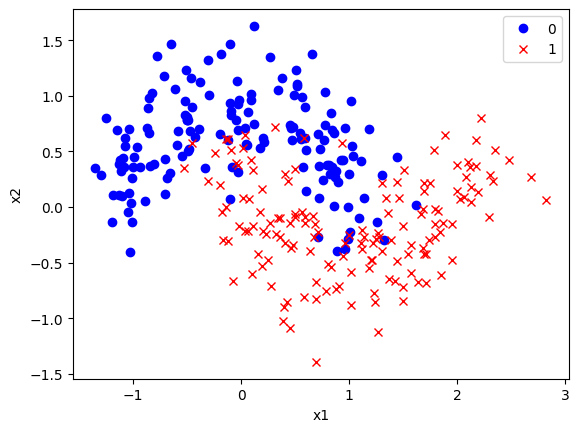

In [ ]:
X_train, y_train = make_moons(n_samples=300, noise=0.3, random_state=7)
X_val,   y_val   = make_moons(n_samples=10000, noise=0.3, random_state=1)
X_test,  y_test  = make_moons(n_samples=10000, noise=0.3, random_state=2)
plot_data(X_train, y_train)

In [ ]:
from sklearn.ensemble import VotingClassifier

@interact(weak_tree=True, soft_voting=False)
def _(weak_tree, soft_voting):
    model = VotingClassifier(
        [('dt', DecisionTreeClassifier(max_depth=1 if weak_tree else None, random_state=0)),
         ('lr', LogisticRegression(penalty=None)),
         ('lr2', make_pipeline(PolynomialFeatures(2), LogisticRegression(penalty=None)))],
        voting='soft' if soft_voting else 'hard')
    model.fit(X_train, y_train)
    try:
        model.predict_proba(X_train)
        print('predict_proba is available')
    except Exception as e:
        print(e)
    print('\nVal accuracy:')
    for estimator in model.estimators_ + [model]:
        print(f'{type(estimator).__name__:>22}: {estimator.score(X_val, y_val):.2%}')

interactive(children=(Checkbox(value=True, description='weak_tree'), Checkbox(value=False, description='soft_v…

In [ ]:
from sklearn.svm import SVC
try:
    VotingClassifier([('svc', SVC() #probability=True)
                      )], voting='soft').fit(X_train, y_train).predict(X_train)
    print('OK')
except Exception as e:
    print(e)

predict_proba is not available when  probability=False


O SVC por padrão não fornece a função `predict_proba`; para isso, é necessário configurar o parâmetro `probability=True`.

In [ ]:
from sklearn.ensemble import VotingRegressor

## Bagging e Pasting

In [ ]:
from sklearn.ensemble import BaggingClassifier

@interact(n_estimators=(1,1001,10), max_samples=(0.05,1,0.05), bootstrap=False)
def _(n_estimators=1, max_samples=1.0, bootstrap=False,):
    model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=n_estimators, max_samples=max_samples, bootstrap=bootstrap, random_state=None)
    model.fit(X_train, y_train)
    if bootstrap:
        print('Method: Bagging')
    else:
        print('Method: Pasting')
    print(f'\n  Val accuracy: {model.score(X_val, y_val):.2%}\n')
    print(model.estimators_[:3], '(...)' if len(model.estimators_) > 3 else '', '\n')

interactive(children=(IntSlider(value=1, description='n_estimators', max=1001, min=1, step=10), FloatSlider(va…

## Floresta Aleatória

Val accuracy (Random Forest): 90.00%


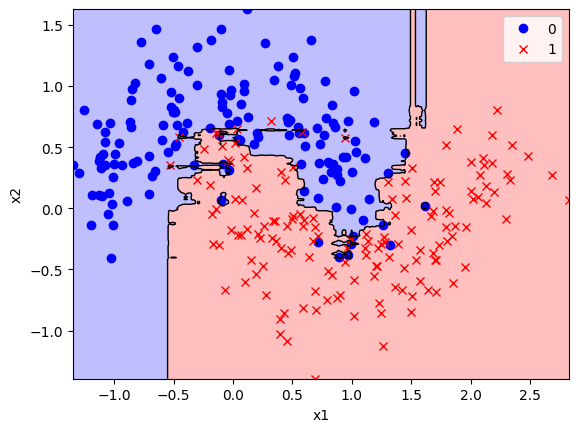

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

#model = BaggingClassifier(DecisionTreeClassifier(max_features='auto'), n_estimators=100)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(f'Val accuracy (Random Forest): {model.score(X_val, y_val):.2%}')
plot_data(X_train, y_train, model, N=300)

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(iris['data'], iris['target'])
pd.Series(model.feature_importances_, index=iris['feature_names']).sort_values(ascending=False)

petal length (cm)    0.460445
petal width (cm)     0.424116
sepal length (cm)    0.090908
sepal width (cm)     0.024531
dtype: float64

## Gradient Boosting

(100, 1) (100,)


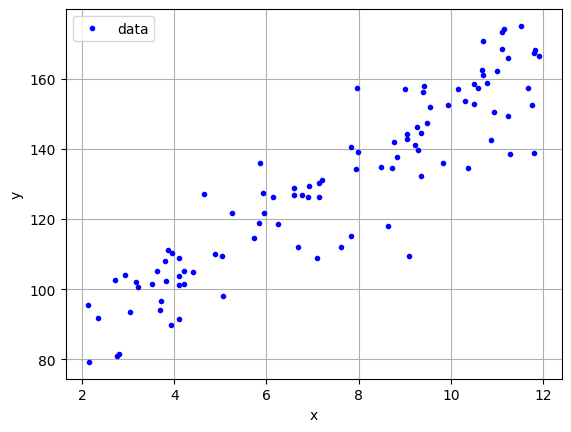

In [ ]:
X_train, y_train = gen_data_reg(n_samples=100, random_state=27)
X_val, y_val = gen_data_reg(n_samples=10000, random_state=1)
print(X_train.shape, y_train.shape)
plot_data(X_train, y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

interactive(children=(IntSlider(value=1, description='n_estimators', min=1), FloatSlider(value=1.0, descriptio…

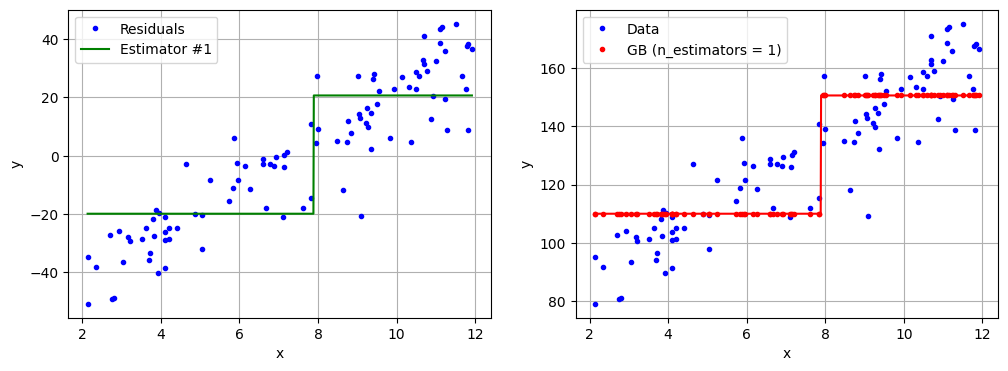

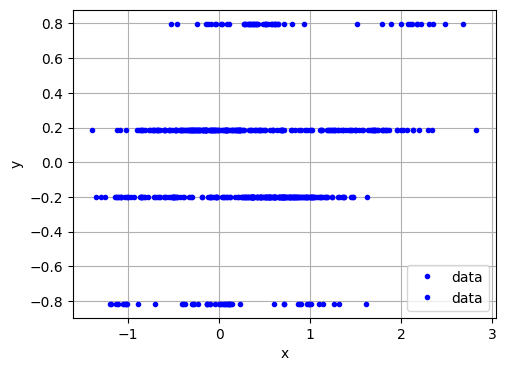

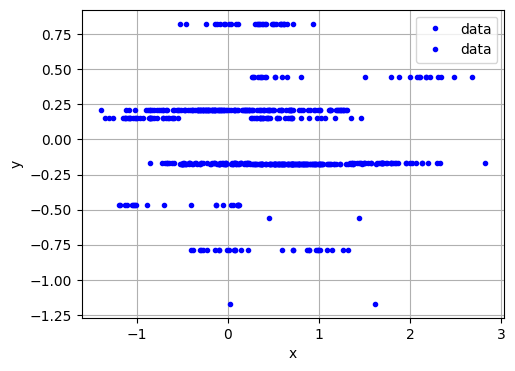

In [ ]:
@interact(n_estimators=(1,100), learning_rate=(0.1, 1, 0.1), max_depth=(1,20))
def _(n_estimators=1, learning_rate=1, max_depth=1):
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    print(f'\nTrain MSE: {mean_squared_error(y_train, model.predict(X_train))}')
    print(f'  Val MSE: {mean_squared_error(y_val, model.predict(X_val))}\n')
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    y_pred = model.init_.predict(X_train)
    for j in range(n_estimators - 1):
        y_pred += learning_rate * model.estimators_[j][0].predict(X_train)
    plot_data(X_train, y_train - y_pred)
    x = np.linspace(X_train.min(), X_train.max(), 1000)
    plt.plot(x, model.estimators_[-1][0].predict(x.reshape(-1, 1)), 'g-')
    plt.legend(['Residuals', 'Estimator #' + str(n_estimators)], loc='upper left')
    plt.subplot(1, 2, 2)
    plot_data(X_train, y_train, model)
    plt.legend(['Data', 'GB (n_estimators = ' + str(n_estimators) + ')'])

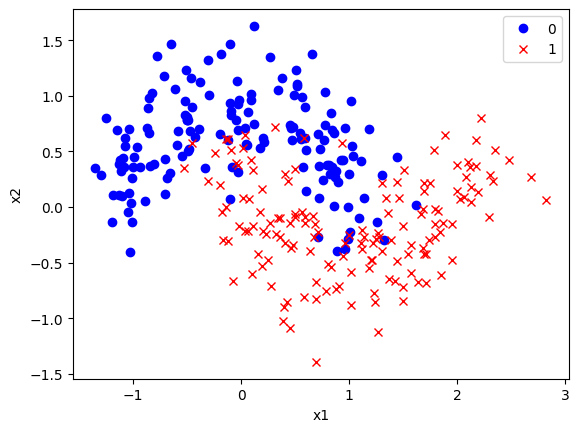

In [ ]:
X_train, y_train = make_moons(n_samples=300, noise=0.3, random_state=7)
X_val,   y_val   = make_moons(n_samples=10000, noise=0.3, random_state=1)
X_test,  y_test  = make_moons(n_samples=10000, noise=0.3, random_state=2)
plot_data(X_train, y_train)

interactive(children=(IntSlider(value=1, description='n_estimators', min=1), FloatSlider(value=1.0, descriptio…

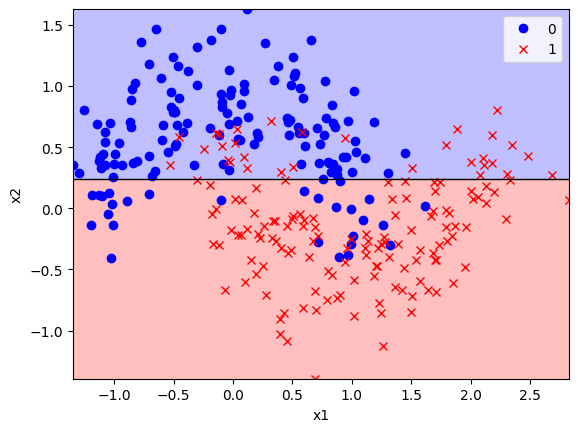

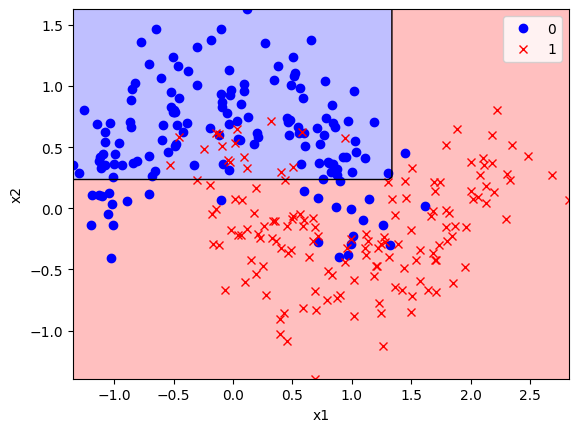

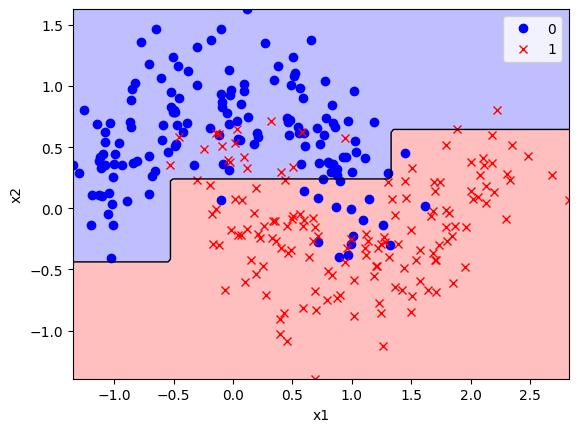

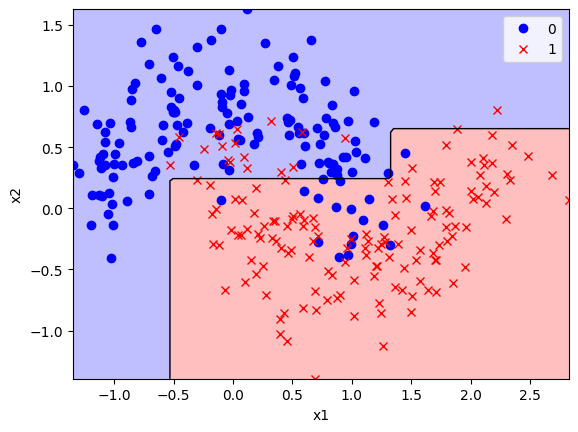

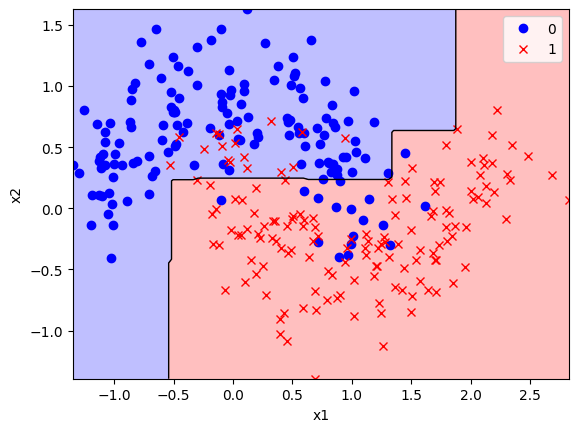

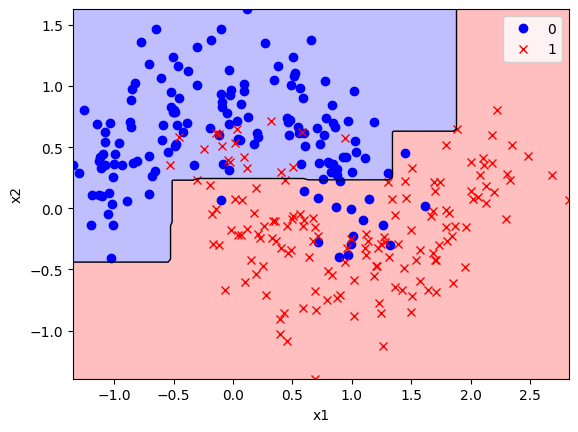

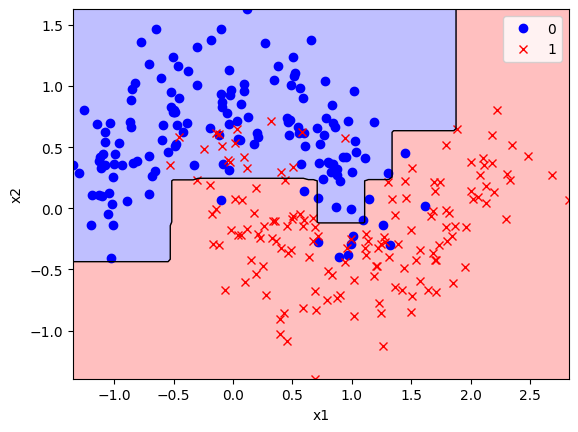

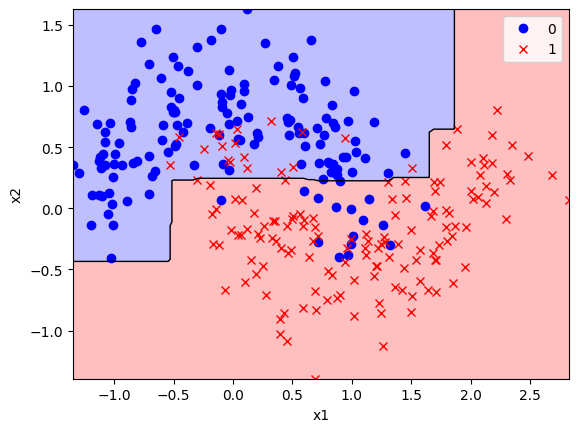

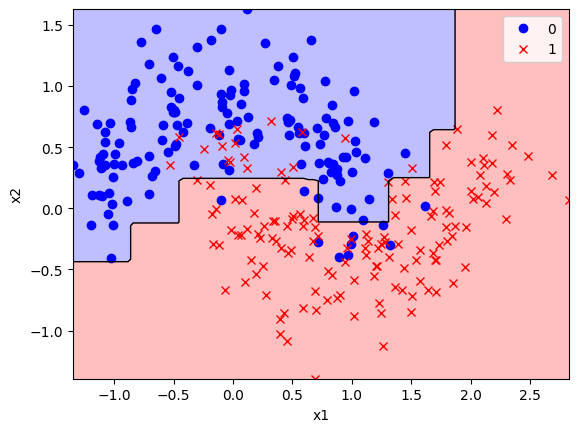

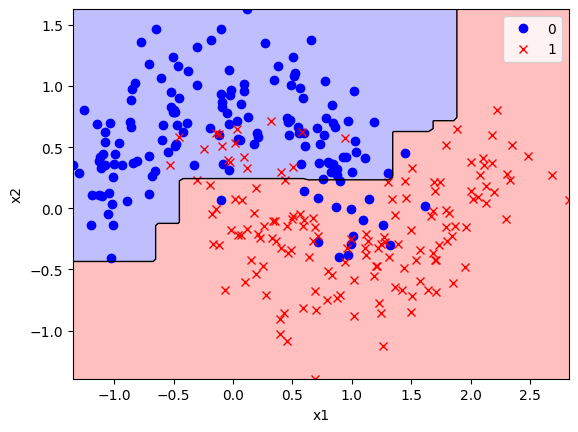

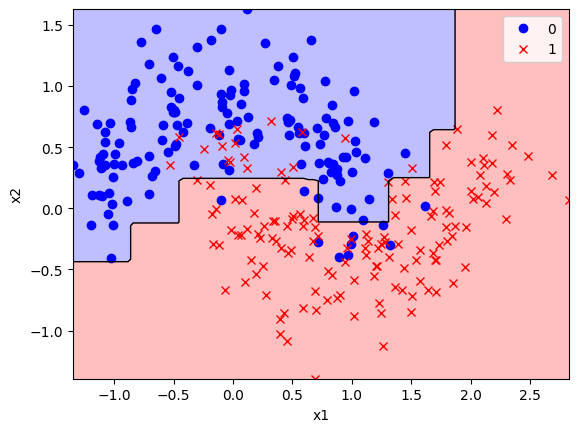

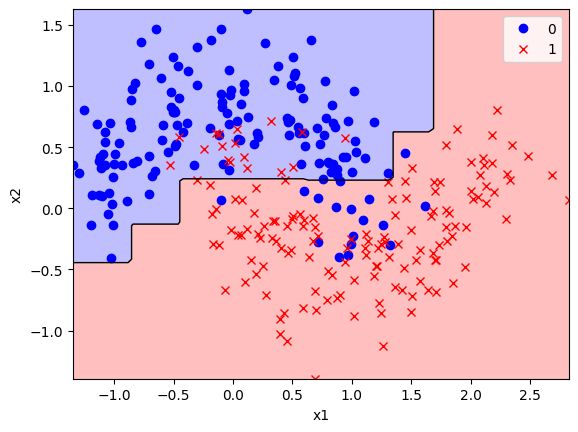

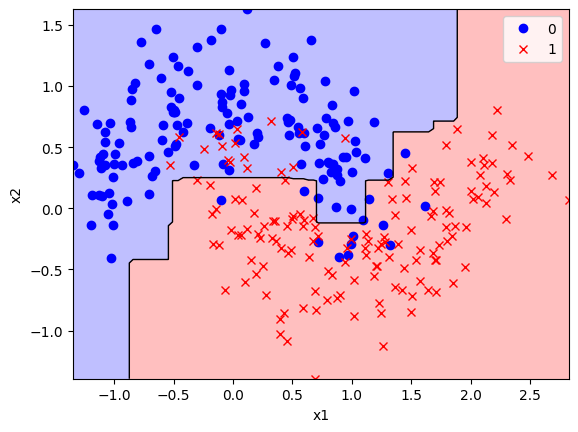

In [ ]:
@interact(n_estimators=(1,100), learning_rate=(0.1, 1, 0.1), max_depth=(1,20))
def _(n_estimators=1, learning_rate=1, max_depth=1):
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
    plot_data(X_train, y_train, model)

interactive(children=(FloatSlider(value=1.0, description='learning_rate', max=1.0, min=0.1), IntSlider(value=1…

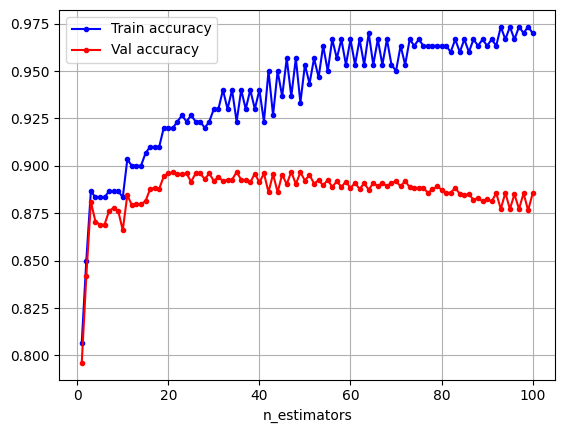

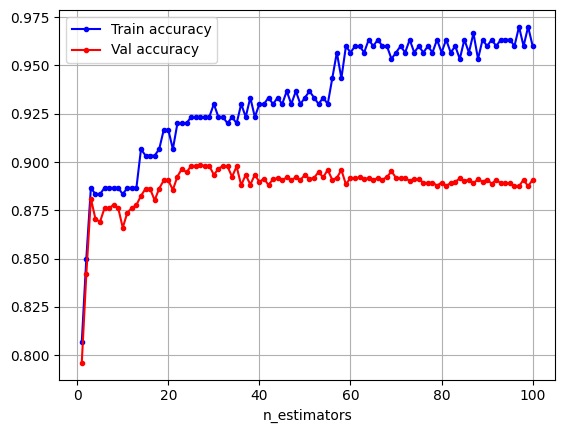

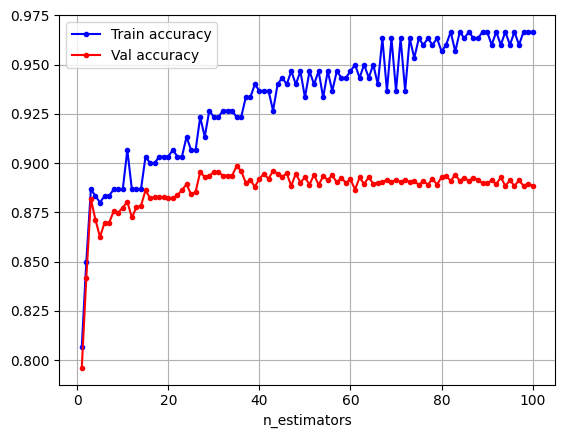

In [ ]:
n_estimators = 100
@interact(learning_rate=(0.1, 1, 0.1), max_depth=(1,10))
def vis(learning_rate=1, max_depth=1):
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    train_accs = np.zeros(n_estimators)
    val_accs = np.zeros(n_estimators)
    ns = np.arange(1, n_estimators+1)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_accs[i] = accuracy_score(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_val)):
        val_accs[i] = accuracy_score(y_val, y_pred)
    j = val_accs.argmax()
    print(f'Best val accuracy (n_estimators = {ns[j]}): {val_accs[j]:.2%}')
    plt.plot(ns, train_accs, 'b.-', label='Train accuracy')
    plt.plot(ns, val_accs, 'r.-', label='Val accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('n_estimators')

In [ ]:
#Early stopping

n_estimators = 1000
@interact(learning_rate=(0.1, 1, 0.1), max_depth=(1,10))
def _(learning_rate=1, max_depth=1):
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_iter_no_change=10, random_state=0)
    model.fit(X_train, y_train)
    print(f'Best val accuracy (n_estimators = {model.n_estimators_}): {model.score(X_val, y_val):.2%}')

interactive(children=(FloatSlider(value=1.0, description='learning_rate', max=1.0, min=0.1), IntSlider(value=1…

  Val accuracy: 89.32%


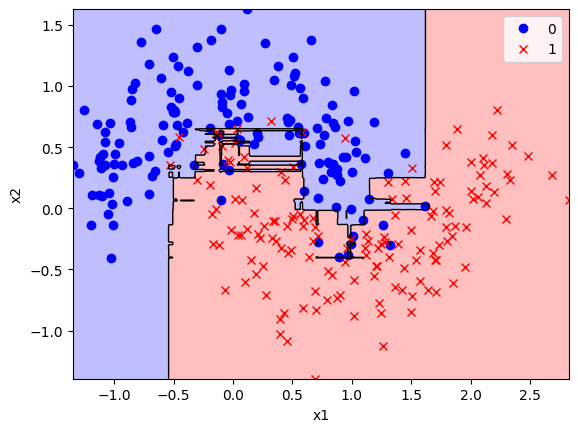

In [ ]:
model = GradientBoostingClassifier(n_estimators=36, learning_rate=0.1, n_iter_no_change=10, max_depth=5)
model.fit(X_train, y_train)
print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
plot_data(X_train, y_train, model, N=300)

Outras bibliotecas de Gradient Boosting (todas com suporte a GPU):
- XGBoost: https://xgboost.readthedocs.io/
- CatBoost: https://catboost.ai/
- LightGBM: https://lightgbm.readthedocs.io/

In [ ]:
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm